导入库

In [19]:
from matplotlib import pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
from scipy import interp
import csv
from sklearn.ensemble import RandomForestClassifier

处理数据

In [20]:
def load_data_feature(file):
    data = []
    with open(file,'r',encoding='utf-8') as f:
        for lines in f.readlines():
            lines = list(lines.split())
            a = []
            for line in lines:              
                a.append(float(line))
            data.append(a)
    data = np.array(data)
    return data

def load_data_label(file):
    data = []
    with open(file,'r',encoding='utf-8') as f:
        for lines in f.readlines():
            data.append(int(lines))
    data = np.array(data)
    return data

def handle_data(data):
    for i in range(len(data)):
            if data[i] == 0 :
                data[i] =-1

建立随机森林并对于每个基学习器进行交叉验证

In [21]:
def Forest(xtrain,ytrain,xtest,ytest):
    #定义n折交叉验证
    KF = KFold(n_splits = 5)

    auc_mean = []
    score_mean = []

    start = time.perf_counter()
    num_learners = 300

    for i in range(1,num_learners+1):
        aucs = []
        scores = []
        starti = time.perf_counter()
        for train_index,test_index in KF.split(xtrain,ytrain):
            #建立模型，并对训练集进行测试，求出预测得分
            #划分训练集和测试集
            X_train,X_test = xtrain[train_index],xtrain[test_index]
            Y_train,Y_test = ytrain[train_index],ytrain[test_index]
        
            model = RandomForestClassifier(n_estimators = i , criterion = 'gini')
            model.fit(X_train,Y_train)

            #利用model.predict获取测试集的预测值
            y_pred = model.predict_proba(X_test)

            #计算fpr(假阳性率),tpr(真阳性率),thresholds(阈值)[绘制ROC曲线要用到这几个值]
            fpr,tpr,threshold=roc_curve(Y_test ,y_pred[:,1] ,pos_label = 1)
            #计算auc
            roc_auc=auc(fpr,tpr)
            aucs.append(roc_auc)

            #计算模型分数
            score = model.score(xtest,ytest)
            scores.append(score)
            
        auc_mean.append(sum(aucs)/5.0)
        score_mean.append(sum(scores)/5.0)
        print("第%d个基学习器运行时间: %f s，AUC分数为：%f，准确度为：%f" % (i,time.perf_counter() - starti,auc_mean[i-1],score_mean[i-1]))
    
    print("RandomForest运行时间: %f s" % (time.perf_counter() - start))

    with open (file = 'RandomForestMain.csv',mode = 'w+',encoding='utf-8') as file:
            for i in range(num_learners):
                file.write(str(i+1)+','+str(auc_mean[i])+',')
                file.write(str(score_mean[i]))
                file.write('\n')

    print('写入完成！')

    

画图

In [22]:
def plot_auc():
    #显示中文标签 
    plt.rcParams['font.sans-serif']=['SimHei'] 
    plt.rcParams['axes.unicode_minus']=False
    
    x = []
    auc_all= []
    with open (file = 'RandomForestMain.csv',mode = 'r+',encoding='utf-8') as file:
        lines = csv.reader(file)
        for line in lines:
            x.append(int(line[0]))
            auc_all.append(float(line[1]))
    
    x=np.array(x)
    auc_all=np.array(auc_all)
    np.round(auc_all,2)
    plt.title('RandomForest')

    # 设置X, Y轴标题
    plt.xlabel('基学习器数量')
    plt.ylabel('AUC')
    plt.xlim(np.min(x)-10,np.max(x)+10)#确定横轴坐标范围
    plt.ylim(np.min(auc_all)-0.05,np.max(auc_all)+0.05)
    plt.plot(x,auc_all,'o',markersize =4) 
    plt.plot(x,auc_all,color='orange') 
    plt.savefig('RandomForest.png',dpi=300)
    plt.show()

In [23]:
def main():
    #导入数据
    xtrain_file = './adult_dataset/adult_train_feature.txt'
    ytrain_file = './adult_dataset/adult_train_label.txt'
    xtest_file = './adult_dataset/adult_test_feature.txt'
    ytest_file = './adult_dataset/adult_test_label.txt'

    #划分训练集和验证集
    xtrain = []
    ytrain = []
    xtest = []
    ytest = []
    xtrain = load_data_feature(xtrain_file)
    ytrain = load_data_label(ytrain_file)
    xtest = load_data_feature(xtest_file)
    ytest = load_data_label(ytest_file)
    handle_data(ytrain)
    handle_data(ytest)
    
    Forest(xtrain,ytrain,xtest,ytest)
    plot_auc()

第1个基学习器运行时间: 0.154360 s，AUC分数为：0.738612，准确度为：0.806179
第2个基学习器运行时间: 0.287604 s，AUC分数为：0.798116，准确度为：0.830907
第3个基学习器运行时间: 0.409292 s，AUC分数为：0.828773，准确度为：0.830981
第4个基学习器运行时间: 0.541228 s，AUC分数为：0.845489，准确度为：0.839174
第5个基学习器运行时间: 0.634795 s，AUC分数为：0.857477，准确度为：0.838069
第6个基学习器运行时间: 0.750535 s，AUC分数为：0.866918，准确度为：0.843265
第7个基学习器运行时间: 0.871200 s，AUC分数为：0.871029，准确度为：0.843855
第8个基学习器运行时间: 0.980176 s，AUC分数为：0.875487，准确度为：0.846742
第9个基学习器运行时间: 1.181374 s，AUC分数为：0.880292，准确度为：0.846103
第10个基学习器运行时间: 1.265955 s，AUC分数为：0.881046，准确度为：0.846803
第11个基学习器运行时间: 1.382302 s，AUC分数为：0.882872，准确度为：0.847258
第12个基学习器运行时间: 1.488011 s，AUC分数为：0.886837，准确度为：0.848965
第13个基学习器运行时间: 1.588247 s，AUC分数为：0.886359，准确度为：0.847810
第14个基学习器运行时间: 1.709589 s，AUC分数为：0.891474，准确度为：0.849162
第15个基学习器运行时间: 2.045839 s，AUC分数为：0.890705，准确度为：0.848400
第16个基学习器运行时间: 2.028861 s，AUC分数为：0.890898，准确度为：0.850341
第17个基学习器运行时间: 2.190266 s，AUC分数为：0.893846，准确度为：0.849370
第18个基学习器运行时间: 2.419643 s，AUC分数为：0.893347，准确度为：0.851446
第19个基学习器运行时间: 2.238

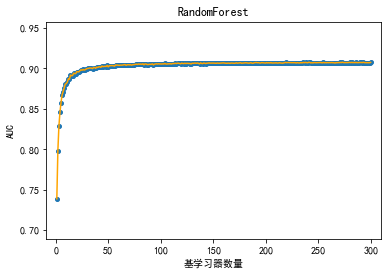

In [24]:
main()